<a href="https://colab.research.google.com/github/ganyiwatakunda/ObjectDetection/blob/main/objectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```

1.   Praise T Ganyiwa R204436Q

2.   Fastion Mateveva R205684K

3.   Shamiso Makainganwa R204437W


```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install inception

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.1 MB/s 
  Created wheel for inception: filename=inception-0.0.3-py3-none-any.whl size=6879 sha256=4c7b49beb04d7a6ed4e9483ef609170e48dadaae778dba78898def8f580869e6
  Stored in directory: /root/.cache/pip/wheels/f5/53/30/fe2172262b53ab331af29fdd82b649b884dc2fd4e2c3225a91
Successfully built inception


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import imageio
import cv2
import os
import pandas as pd

# Functions and classes for loading and using the Inception model.

from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow_docs.vis import embed
from imutils import paths

In [ ]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

96112376/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
train_df = pd.read_csv("test.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 224
Total videos for testing: 224


,video_name,tag
32,v_CricketShot_g05_c05.avi,CricketShot
156,v_ShavingBeard_g05_c03.avi,ShavingBeard
10,v_CricketShot_g02_c04.avi,CricketShot
220,v_TennisSwing_g07_c04.avi,TennisSwing
88,v_PlayingCello_g07_c01.avi,PlayingCello
190,v_TennisSwing_g03_c02.avi,TennisSwing
113,v_Punch_g05_c03.avi,Punch
8,v_CricketShot_g02_c02.avi,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot
104,v_Punch_g03_c03.avi,Punch


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def classify(image_path):
    # Display the image.
    display(Image(image_path))

    # Use the Inception model to classify the image.
    pred = model.classify(image_path=image_path)

    # Print the scores and names for the top-10 predictions.
    model.print_scores(pred=pred, k=10, only_first_name=True)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


1/1 [==============================] - 0s 188ms/step
Frame features in train set: (224, 20, 2048)
Frame masks in train set: (224, 20)


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

   
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

tf.keras.models.save_model(sequence_model,'my_model.hdf5')


Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 1.6086 - accuracy: 0.2628
Epoch 1: val_loss improved from inf to 1.61484, saving model to /tmp/video_classifier
5/5 [==============================] - 14s 873ms/step - loss: 1.6086 - accuracy: 0.2628 - val_loss: 1.6148 - val_accuracy: 0.0000e+00
Epoch 2/10
4/5 [=======================>......] - ETA: 0s - loss: 1.6068 - accuracy: 0.2891
Epoch 2: val_loss did not improve from 1.61484
5/5 [==============================] - 0s 68ms/step - loss: 1.6064 - accuracy: 0.3141 - val_loss: 1.6197 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.3141
Epoch 3: val_loss did not improve from 1.61484
5/5 [==============================] - 0s 71ms/step - loss: 1.6045 - accuracy: 0.3141 - val_loss: 1.6247 - val_accuracy: 0.0000e+00
Epoch 4/10
4/5 [=======================>......] - ETA: 0s - loss: 1.6023 - accuracy: 0.3047
Epoch 4: val_loss did not improve from 1.61484
5/5 [==

Test video path: v_PlayingCello_g06_c02.avi
1/1 [==============================] - 3s 3s/step
  PlayingCello: 20.77%
  CricketShot: 20.56%
  ShavingBeard: 20.10%
  TennisSwing: 19.56%
  Punch: 19.02%



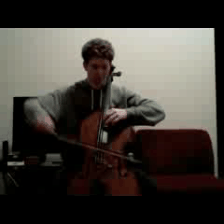

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
model.save('my_model.hdf5')

End of edit

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os



dataset_path =os.listdir ('/content/drive/MyDrive/dataset/train')

label_types = os.listdir ('/content/drive/MyDrive/dataset/train')
print (label_types)  

FileNotFoundError: ignored

In [ ]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/drive/MyDrive/dataset/train' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/dataset/train' + '/' +item) + '/' + room))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())

        tag                                         video_name
0     dance  /content/drive/MyDrive/dataset/train/dance/vid...
1     dance  /content/drive/MyDrive/dataset/train/dance/vid...
2     dance  /content/drive/MyDrive/dataset/train/dance/vid...
3  amapiano  /content/drive/MyDrive/dataset/train/amapiano/...
4  amapiano  /content/drive/MyDrive/dataset/train/amapiano/...
        tag                                         video_name
4  amapiano  /content/drive/MyDrive/dataset/train/amapiano/...
5  amapiano  /content/drive/MyDrive/dataset/train/amapiano/...
6     petit  /content/drive/MyDrive/dataset/train/petit/vid...
7     petit  /content/drive/MyDrive/dataset/train/petit/vid...
8     petit  /content/drive/MyDrive/dataset/train/petit/vid...


In [ ]:
df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

In [ ]:
dataset_path = os.listdir('/content/drive/MyDrive/dataset/test')
print(dataset_path)

room_types = os.listdir('/content/drive/MyDrive/dataset/test')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/drive/MyDrive/dataset/test' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/dataset/test' + '/' +item) + '/' + room))
    
# Build a dataframe        
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['amapiano', 'petit', 'dance']
Types of activities found:  3
        tag                                         video_name
0  amapiano  /content/drive/MyDrive/dataset/test/amapiano/v...
1     petit  /content/drive/MyDrive/dataset/test/petit/vid7...
2     dance  /content/drive/MyDrive/dataset/test/dance/vid4...
        tag                                         video_name
0  amapiano  /content/drive/MyDrive/dataset/test/amapiano/v...
1     petit  /content/drive/MyDrive/dataset/test/petit/vid7...
2     dance  /content/drive/MyDrive/dataset/test/dance/vid4...


In [ ]:
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


train_df.sample(9)

Total videos for training: 9
Total videos for testing: 3


,Unnamed: 0,video_name,tag
4,4,/content/drive/MyDrive/dataset/train/amapiano/...,amapiano
7,7,/content/drive/MyDrive/dataset/train/petit/vid...,petit
3,3,/content/drive/MyDrive/dataset/train/amapiano/...,amapiano
0,0,/content/drive/MyDrive/dataset/train/dance/vid...,dance
6,6,/content/drive/MyDrive/dataset/train/petit/vid...,petit
5,5,/content/drive/MyDrive/dataset/train/amapiano/...,amapiano
1,1,/content/drive/MyDrive/dataset/train/dance/vid...,dance
8,8,/content/drive/MyDrive/dataset/train/petit/vid...,petit
2,2,/content/drive/MyDrive/dataset/train/dance/vid...,dance


In [ ]:
IMG_SIZE = 224


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels

['amapiano', 'dance', 'petit']


array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2]])

In [ ]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    
    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values
    
    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

1/1 [==============================] - 0s 158ms/step
Frame features in train set: (9, 20, 2048)
Frame masks in train set: (9, 20)
train_labels in train set: (9, 1)
test_labels in train set: (3, 1)


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

EPOCHS = 10
# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.0434 - accuracy: 0.1667
Epoch 1: val_loss improved from inf to 1.72131, saving model to ./tmp/video_classifier
1/1 [==============================] - 11s 11s/step - loss: 1.0434 - accuracy: 0.1667 - val_loss: 1.7213 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.6667
Epoch 2: val_loss did not improve from 1.72131
1/1 [==============================] - 0s 103ms/step - loss: 1.0127 - accuracy: 0.6667 - val_loss: 1.8808 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.9670 - accuracy: 0.5000
Epoch 3: val_loss did not improve from 1.72131
1/1 [==============================] - 0s 64ms/step - loss: 0.9670 - accuracy: 0.5000 - val_loss: 1.8837 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8333
Epoch 4: val_loss did not improve from 1.72131
1/1 [==

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)


Test video path: /content/drive/MyDrive/dataset/test/amapiano/vid2.mp4
1/1 [==============================] - 0s 25ms/step
  dance: 54.76%
  amapiano: 27.27%
  petit: 17.97%


In [ ]:
sequence_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 16)       99168       ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']                

In [ ]:
sequence_model.save('model.h5') 

In [ ]:
new_model = tf.keras.models.load_model('model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 16)       99168       ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']                